In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost, Target Encoding - DGI Base Hierarchical
Mean Encode NAICS grouped by DGI base cluster.  Also in this script I calculate the mean encodings at all levels

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
from sklearn.preprocessing import TargetEncoder

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [6]:
import sklearn as sk
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [7]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

##### Get loans data, append clusters

In [8]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [9]:
sba_loans.filter(like='NAICS').columns

Index(['NAICS', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc', 'NAICS_num',
       'menc_NAICS', 'cenc_NAICS'],
      dtype='object')

In [10]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

In [11]:
embed_df.columns

Index(['source', 'emb_000', 'emb_001', 'emb_002', 'emb_003', 'emb_004',
       'emb_005', 'emb_006', 'emb_007', 'NAICS_2', 'NAICS_sector',
       'NAICS_sector_sel', 'NAICS_sector_desc', 'NAICS_sector_comb',
       'train_count', 'NAICS_sector_filt', 'tsne_0', 'tsne_1', 'NAICS_orig',
       'all_target_mean', 'menc_NAICS', 'cluster', 'cluster_20', 'cluster_80',
       'NC__0', 'NC__1', 'NC__2', 'NC__3', 'NC__4', 'NC__5', 'NC__6', 'NC__7',
       'NC__8', 'NC__9'],
      dtype='object')

In [12]:
sba_loans = sba_loans.drop(columns = 'cluster', errors='ignore') \
    .merge(embed_df[['NAICS_orig', 'cluster', 'cluster_20', 'cluster_80']] \
               .rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

## Fit the Target Encoder(s)

##### Get raw grouped encodings

In [13]:
# per high-level cluster 
grouped = sba_loans.groupby('cluster')
sba_loans = pd.concat([sba_loans.drop(columns='menc_cluster', errors='ignore'),
                       pd.concat([sg_plot.mean_enc_grp(g, feature_out='menc_cluster') for n, g in grouped])],
                      axis=1)

In [14]:
# Missle level (k=20)
grouped = sba_loans.groupby('cluster_20')
sba_loans = pd.concat([sba_loans.drop(columns='menc_cluster_20', errors='ignore'),
                       pd.concat([sg_plot.mean_enc_grp(g, feature_out='menc_cluster_20') for n, g in grouped])],
                      axis=1)

In [15]:
# Lowest level (k=80)
grouped = sba_loans.groupby('cluster_80')
sba_loans = pd.concat([sba_loans.drop(columns='menc_cluster_80', errors='ignore'),
                       pd.concat([sg_plot.mean_enc_grp(g, feature_out='menc_cluster_80') for n, g in grouped])],
                      axis=1)

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


##### Blend in Missing

In [16]:
sba_loans['menc_cluster_20'] = sba_loans['menc_cluster_20'].fillna(sba_loans['menc_cluster'])
sba_loans['menc_cluster_80'] = sba_loans['menc_cluster_80'].fillna(sba_loans['menc_cluster_20'])

##### Save the new columns

In [17]:
sba_loans[['LoanNr_ChkDgt', 'menc_cluster', 'menc_cluster_20', 'menc_cluster_80']] \
    .to_parquet(Path(setup.temp_path).joinpath('65_DATA_hierarchical_target_encodings.parquet'))

#### Set the predictor features.  Inlcude the mean-encoded NAICS

In [18]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [19]:
predictor_features = setup.predictor_features + ['menc_cluster']
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_cluster']


In [20]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,menc_cluster,target
NoEmp,1.000000,0.062158,-0.013926,0.095658,-0.041427,0.001610,0.006409,-0.026755,-0.027403
CreateJob,0.062158,1.000000,-0.062740,0.134686,0.039302,0.009062,0.050517,0.005257,-0.010002
LowDoc,-0.013926,-0.062740,1.000000,-0.133141,0.153034,-0.120001,0.040841,-0.083212,-0.079523
DisbursementGross,0.095658,0.134686,-0.133141,1.000000,-0.065443,-0.007016,0.085712,-0.188194,-0.120788
new_business,-0.041427,0.039302,0.153034,-0.065443,1.000000,-0.047592,0.137325,0.027158,0.013878
urban_flag,0.001610,0.009062,-0.120001,-0.007016,-0.047592,1.000000,-0.006588,0.055877,0.053785
franchise_flag,0.006409,0.050517,0.040841,0.085712,0.137325,-0.006588,1.000000,0.028868,-0.012731
menc_cluster,-0.026755,0.005257,-0.083212,-0.188194,0.027158,0.055877,0.028868,1.000000,0.231538
target,-0.027403,-0.010002,-0.079523,-0.120788,0.013878,0.053785,-0.012731,0.231538,1.000000


In [21]:
with open(Path(setup.temp_path).joinpath('65_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [22]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [23]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [24]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [25]:
xgb_model = xgb_model.set_params(**xgb_params)

In [26]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50054	validation_1-logloss:0.50405
[1]	validation_0-logloss:0.49313	validation_1-logloss:0.49681
[2]	validation_0-logloss:0.48688	validation_1-logloss:0.49073
[3]	validation_0-logloss:0.48162	validation_1-logloss:0.48562
[4]	validation_0-logloss:0.47721	validation_1-logloss:0.48137
[5]	validation_0-logloss:0.47343	validation_1-logloss:0.47770
[6]	validation_0-logloss:0.47016	validation_1-logloss:0.47456
[7]	validation_0-logloss:0.46734	validation_1-logloss:0.47180
[8]	validation_0-logloss:0.46490	validation_1-logloss:0.46948
[9]	validation_0-logloss:0.46283	validation_1-logloss:0.46755
[10]	validation_0-logloss:0.46097	validation_1-logloss:0.46578
[11]	validation_0-logloss:0.45944	validation_1-logloss:0.46439
[12]	validation_0-logloss:0.45813	validation_1-logloss:0.46319
[13]	validation_0-logloss:0.45701	validation_1-logloss:0.46217
[14]	validation_0-logloss:0.45603	validation_1-logloss:0.46127
[15]	validation_0-logloss:0.45515	validation_1-logloss:0.46049
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [28]:
xgb_model.save_model(Path(setup.temp_path).joinpath('65_MODEL_xgboost.json'))

In [29]:
with open(Path(setup.temp_path).joinpath('65_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [30]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [31]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.183934,0.114476,0.015789,0.653366,0.168746
1,0.282025,0.109444,0.015873,0.666285,0.288471


## Decision Threshold
Max f1, on training data

In [32]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [33]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [34]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('65_REPORT_thresh_tune.csv'), index=False)

In [35]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.452582
11,0.22,0.452018


##### Apply decision threshold
All datasets

In [36]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [37]:
pred_df['predict_bin'].value_counts()

predict_bin
0    409747
1    278334
Name: count, dtype: int64

In [38]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('65_DATA_combined_predictions.parquet'))

## Metrics

In [39]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('65_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.674361,0.439103,0.331322,0.650818,0.372408,0.731179,NaN
1,train,0.663235,0.452582,0.339099,0.680227,0.389785,0.733101,NaN
2,val,0.660004,0.449343,0.338380,0.668592,0.384550,0.726131,NaN
0,test,0.659719,0.449400,0.336793,0.675129,0.382625,0.727987,0.0
1,test,0.695398,0.421747,0.321928,0.611285,0.356434,0.734168,1.0


## Lift
Test data

In [40]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

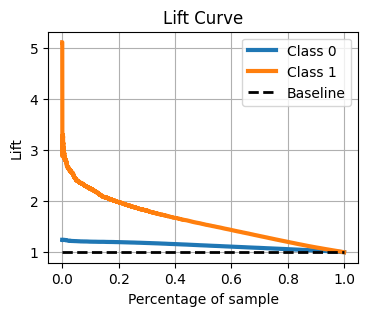

In [41]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('65_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [42]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [43]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('65_REPORT_importance_gain.csv'), index=True)

In [44]:
feat_impgain.head()

,importance
urban_flag,308.363922
LowDoc,126.259529
menc_cluster,86.181396
DisbursementGross,47.138664
franchise_flag,19.624699


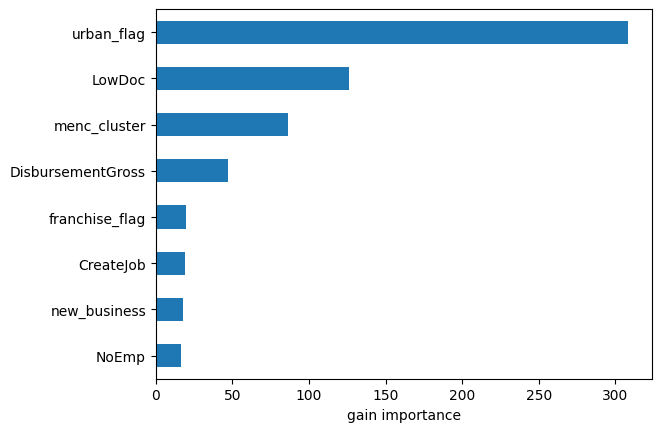

In [45]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('65_PLOT_importance_gain.png'))

##### Permutation Importance

In [ ]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [ ]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [ ]:
perm_importance_df.head(5)

In [ ]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('65_DATA_importance_perturb.csv'),
            index=False)

In [ ]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('65_PLOT_importance_perturb.png'))

## PDP Plot - NAICS mean encoded

In [ ]:
results = partial_dependence(xgb_model, train_df[predictor_features], ['menc_cluster'])
pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})

In [ ]:
plt.close()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 3))
pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax)
ax.set_ylabel('effect')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_pdp_naics_meanenc.png'),
               bbox_inches='tight')

## NAICS variation plot

In [ ]:
sba_loans['cluster_desc'] = ''
naics_info = sg_plot.naics_variance_data(sba_loans,
                                        naics_sector_feat='cluster',
                                        naics_sector_desc_feat='cluster_desc')

In [ ]:
# Plot higher volume NAICS
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 100],
                                  naics_sector_feat='cluster',
                                  naics_sector_desc_feat='cluster_desc',
                                  num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_naics_counts_rates_100.png'),
           bbox_inches='tight')

In [ ]:
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 100],
                                  naics_sector_feat='cluster',
                                  naics_sector_desc_feat='cluster_desc',
                                  xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_naics_counts_rates_100_all.png'),
           bbox_inches='tight')

In [ ]:
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 150],
                                  naics_sector_feat='cluster',
                                  naics_sector_desc_feat='cluster_desc',
                                  xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_naics_counts_rates_150_all.png'),
           bbox_inches='tight')

In [ ]:
lm_cluster = ols('target ~ C(cluster)',data=sba_loans).fit()
res_cluster = sm.stats.anova_lm(lm_cluster, typ=1)
res_cluster

In [ ]:
res_cluster['sum_sq'].transform(lambda x: x/x.sum())